In [1]:
import pandas as pd
import numpy as np
import gzip
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, cityblock
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# Toggle on-off code text  
from IPython.display import HTML

df_listings = pd.read_csv('singapore_listings_20190318.csv', 
                          low_memory=True).drop(columns='Unnamed: 0')

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click to toggle on/off the raw code.">
</form>''')

<img src="Airbnb-1024x576.jpeg" height=500 width=1000>

# Exploring Market Segmentation within Airbnb User Base

## 1 Executive Summary

Airbnb is one of the largest online vacation marketplaces that offer more than 7 million locally hosted accommodations of lodging in different countries such as Singapore. Airbnb service allows any person traveling to Singapore to book from 1249 accommodations. Moreover, the service provides the traveler with information about the listing - pricing, property type, the minimum number of nights. While the provision of extra information about the lodging benefits the travelers, this service could provide the Airbnb information for market segmentation. Hence, Airbnb would be able to determine the ideal target audience and identify the right market for the different types of listings.

The market segmentation model uses the Singapore Airbnb data dated May 2019, containing details about the Singapore listings. Only those  features deemed relevant were selected because they can potentially give information about the booking preferences of different customers. The selected features include `property_type`, `room_type`, `accomodates` `bathrooms` `bedrooms`, `beds`, `bed_type`, `amenities`, `price`, `minimum_nights`, `instant_bookable` and `neighborhood_overview`. Six (6) features are categorical and the rest numerical.

In this study, the native data underwent several pre-processing steps in preparation for machine learning. The steps include feature selection, handling of outliers, imputation of missing values, bivariate analysis, feature engineering and dimensionality reduction. Due to one-hot encoding and vectorization of some features, the original number of features increased from 12 to 8000+. By Singular Value Decomposition, the dimension was reduced to 160+ without loosing information.

The clustering algorithms used were Kmeans and Agglomerative clustering using ward linkage. By visual comparison, KMeans resulted to more defined and interpretable clusters than Agglomerative clustering. Using several validaton criteria, the best value of k selected was k=4. Cluster labels were then assigned to the objects.

The cluster segments found are named A, B, C and D. Segment A customers are short-term travelers mostly staying a maximum of 4 nights in a place. Segment B are short to medium-term travelers spending 6 to 18 nights. Segment C customers are long term travelers staying from a minimum of 18 nights to a maximum of 30 nights, while Segment D are medium-term travelers who stay around 18-20 nights. Segment D are low-budget guests with a budget ranging from $30$ to $100$ a night. Segments A, B, and C are closely similar having guests with a wide budget ranging from $0$ - $700$, and having close mean prices.

It was also interesting to note that  the top amenities are parking, oven, blanket, and cooking-related amenities. In addition, the top customer preferences for location are those walking distance to MRT, bus terminals, malls and parks.

This study culminates with a recommendation to use a density-based clustering algorithm to accurately segregate and cluster the dataset. Based on 2D plots of the truncated data, the shape of the data is not convex, i.e. elongated. Thus, density-based algorithms may give more defined and interpretable clusters.

## 2 Introduction

### Background

Airbnb, an online vacation marketplace, was founded in 2008 by Brian Chesky, Jose Gebbia, and Nate Blecharcyk in San Francisco. The concept started with renting out air mattresses in Brian and Joe's apartment to eventually turning into a \$31 billion company, becoming the largest accommodation provider in the world (Aydin, 2019). Despite being the largest, Airbnb has around more than 7 million listings without having to own any real estate property (McRae, 2015).

The Airbnb business model is a multi-sided marketplace that turns any interdependent property owner into a host and connects the host with guests. With this model, Airbnb has disrupted the hospitality landscape by targeting mass markets with its review & rating system and customized travel experience. Furthermore, Airbnb's core value proposition lies in information-based offerings to the right market segments. Hence, Airbnb uses algorithms to offer the best value propositions, matching the right traveler or guest based on millions of listing features. Then, the algorithm extracts the guest or traveler experience and uses it to offer better value propositions to future guests (Business Models Inc, n.d.).

<img src="p_1_90271599_exclusive_airbnb_will_start_selling_houses_in_2019.jpg" height=250 width=1000>

### Problem Statement
Airbnb has a tremendously increasing and diverse user base due to its dedication to understanding its customer needs and wants. Despite the large and growing user base, Airbnb market segmentation is mostly between the users and non-users. There is a  gap in the further exploration of distinct customer segments within the Airbnb user base (Lutz & Newlands, 2018). Airbnb must consider conducting a more in-depth market segmentation within its user base, allowing Airbnb to understand its customers more and to market listings to the proper target users.  With the Airbnb's booking history, the proposed market segmentation model hopes to find distinct customer segments within the current user base.

### Scope & Limitations
The market segmentation model explored Singapore Airbnb data dating in May 2019 due to time constraints. The market segmentation model is also limited to only using Airbnb listing features that are deemed relevant for the analysis. Furthermore, the model only accounted for the active Airbnb users that have already booked a place through Airbnb. Not included in the market segment analysis are other Airbnb registered users who have yet to book a place or who only surfs through listings. The market segmentation model assumes that the limited Singapore Airbnb data, relevant listing features, and active Airbnb users to be a representation of the overall Airbnb data.

## 3 Data Scope and Description

The market segmentation model uses the Singapore Airbnb data from Inside Airbnb website. Among the seven files in the dataset, the `listings.csv.gz` file is the only necessary dataset for the model, containing details about the Singapore listings. Only those listing features deemed relevant were used because they can potentially give information about the booking preferences of different customers. Eventually, customers with similar booking preferences can be identified as the market segments.  The following features were selected from the file which originally contains 120+ columns.

- `property_type` - the property type of the listing (e.g. apartment, villa, house, etc.)
- `room_type` - room space available for the guest (private room, entire home, hotel room, or shared room)
- `accomodates` - maximum number of occupants
- `bathrooms` - number of bathrooms in the listing
- `bedrooms`- number of bedrooms in the listing
- `beds` - number of beds in the place
- `bed_type` - bed type available 
- `amenities` - amenities available
- `price` - price per night
- `minimum_nights` - minimum number of nights per booking
- `instant_bookable` - whether instant booking is available 
- `neighborhood_overview` - description of neighborhood

Moreover, the table provided shows the data types of the listing features for data pre-processing. Short summary statistics for these features are given in Table 3.2.

**Table 3.1**. Data Feature Type and Subtype

| Data | Feature Type | Subtype |
| ---- | --------- | ------ |
| `property_type` | Categorical | Nominal |
| `room_type` | Categorical | Nominal |
| `accomodates` | Numerical | Discrete |
| `bathrooms` | Numerical | Discrete |
| `bedrooms` | Numerical | Discrete |
| `beds` | Numerical | Discrete |
| `bed_type` | Categorical | Nominal |
| `amenities` | Categorical | Nominal |
| `price` | Numerical | Continuous |
| `minimum_nights` | Numerical | Discrete |
| `instant_bookable` | Categorical | Nominal |
| `neighborhood_overview` | Categorical | Nominal |

**Table 3.2**. Short Summary Statistics of Seelcted Features

In [3]:
## selection of relevant features

data = df_listings[['property_type', 'room_type', 'accommodates', 
                    'bathrooms', 'bedrooms', 'beds', 
            'bed_type', 'amenities', 'price', 'minimum_nights', 
            'instant_bookable',
            'neighborhood_overview']].copy()

In [4]:
data.describe()

,accommodates,bathrooms,bedrooms,beds,minimum_nights
count,7975.000000,7969.000000,7969.000000,7960.000000,7975.000000
mean,3.449655,1.514054,1.313214,2.030276,15.844639
std,2.638763,1.095349,0.953238,2.263175,40.880622
min,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,1.000000,1.000000,1.000000,3.000000
75%,4.000000,2.000000,2.000000,2.000000,7.000000
max,16.000000,21.000000,10.000000,36.000000,1000.000000


## 4 Methodology

In this study, the objective is to come up with interpretable clusters from the listing that will represent as customer segments. In order to come up with representative clusters, the native data needs to undergo pre-processing steps in preparation for machine learning. The overview of the pre-processing steps is laid out below:

<img src="preprocessing1.png" height=250 width=1000>

**Figure 4.1.** Pre-processing Pipeline

The first step was initial feature selection. There are only 12 features selected out of 106 from the raw data. The initial features selected are shown in **Table 1**. These features were selected with the most logic and that will give the most information necessary to answer the problem statement.

The second step is converting some features into their proper form. This include removing currency signs for numerical features. Further discussion is given in Section 5.1.

The third step is imputation of missing values. There are several missing values in the data set. The techniques used for imputation and the underlying assumptions were discussed in Section 5.2.

The fourth step is outlier detection and filtering. In this step, outliers are objectively identified and treated. The techniques used for outlier detection is given in Section 5.3

The fifth step is bivariate analysis. In this step, collinearities between features are handled objectively. As a result, one feature was dropped due to exceeding a threshold for a measure of collinearity. The technique is demonstrated in Section 6.

The last step is feature engineering. This step is composed of four sub-steps given in **Figure 4.2**. The initial step is vectorization of categorical-nominal features. There are two categorical-nominal features that were vectorized. The vectorization was necessary to extract the relevant information and transform into a form usable for machine learning. The second sub-step is logarithmic transformation of numerical-continuous features. Skewness was checked to determine suitability of log-transformation. This technique was demonstrated in Section 8.2. Third sub-step is One-Hot encoding of nominal categorical features. This is given is Section 8.3. The last sub-step under feature engineering is dimensionality reduction by Singular Value Decomposition. This technique is demonstrated in Section 8.4. 

<img src="feature_engineering.png" height=250 width=1000>

**Figure 4.2**. Feature Engineering Pipeline

There is no post-processing necessary since the results of the clustering were already in usable form. Also, there is no scaling done since the data is mixed of discrete, continuous, and sparse features. In addition, the values of the features are not of nth magnitude from each other. Thus, scaling of the data will not significantly affect the clustering.

## 5 Imputation, Outliers, and Multivariate Data Analysis

Most of the listing features contain missing values, outliers, and wrong inputs (like typographical error). To address this, the following methodologies were applied for handling of outliers, treatment of missing values, imputation and converting some values of features into proper form. This section is divided into the following:

- **5.1** Converting values of features into Proper Form
- **5.2** Treatment of Missing Values
- **5.3** Handling of Outliers

### 5.1 Converting Values of Features into Proper Form

The type and subtypes of each feature are shown in Table  3.1. Most of the categorrical features can be converted into desired subtype by one-hot encoding. The categorical-nominal features `property_type`, `room_type`, `bed_type`, and `instant_bookable` will be on-hot encoded in subsequent sections. On the other hand, `amenities` and `neighborhood_overview` will be vectorized before on-hot encoding. For numerical features, the '`price` is given as `str` object. Thus, it must be stripped and converted as `float` object instead. Other numerical features `accomodates`, `bedrooms`, `beds` and `minimum_nights` will not be changed.


In [4]:
## concert price into float

def convert(x):
    """Converts the values under the feature `price` into `float`.
    """
    try:
        return int(x.strip('$').split('.')[0].split(',')[0])*1000+int(
            x.strip('$').split('.')[0].split(',')[1])
    except IndexError:
        return int(x.strip('$').split('.')[0])

data['price'] = data['price'].apply(lambda x: convert(x))

### 5.2 Treatment of Missing Values

The following features shown in Table N.n have missing values. The number of missing are also given in the first column. The type of imputation or handling, and the expected error for each is discussed below. The features `bathrooms`, `bedrooms` and `beds` are all numerical-discrete types, while the feature `neghborhood_overview` is given as string or text description. The `neighborhood_overview` will be vectorized in the subsequent section, then it will be one-hot encoded. 

**Table 5.2.1** Number of Missing Values

In [5]:
na = data.isna().sum()[data.isna().sum()>0].to_frame()
na.columns = ['Number of Missing Values']
display(na)

,Number of Missing Values
bathrooms,6
bedrooms,6
beds,15
neighborhood_overview,3234


*Feature: Bathroom*<br><br>
From Figure 5.2.1, more than **70%** of the values of the feature_bathroom is **1**, having **5000** occurances. The next most frequent value is **2** with **1500** occurances. Thus, missing values were imputed by the most frequent value, which is **1**. Since there are only **6** missing values, the maximum possible error due to this imputation would only be **<0.1%**.

*Feature: bedrooms*<br><br>
From Figure 5.2.1, more than **60%** of the values of the feature_bedhroom is **1**, having **5000** occurances. The next most frequent value is **2** with **1400** occurances. The third and fourth most frequent values are **0** and **3**, with **<1000** occurances. Thus, missing values were imputed by the most frequent value, which is **1**. Since there are only **6** missing values, the maximum possible error due to this imputation would only be **<0.1%**.

*Feature: beds*<br><br>
From Figure 5.2.1, more than **50%** of the values of the feature_bedhroom is **1**, having **4500** occurances. The next most frequent value is **2** with **1800** occurances. The third and fourth most frequent values are **3** and **4**, with **<1000** occurances. Thus, missing values were imputed by the most frequent value, which is **1**. Since there are only **15** missing values, the maximum possible error due to this imputation would only be **<0.2%**.

*Feature: Neighborhood Overview*<br><br>
The  values under the neighborhood overview are the descriptions in text form. Thus, missing values would not be imputed by any method. Instead, missing values were replaced by empty sring `""` to be consistent with the data type of other values under this feature.

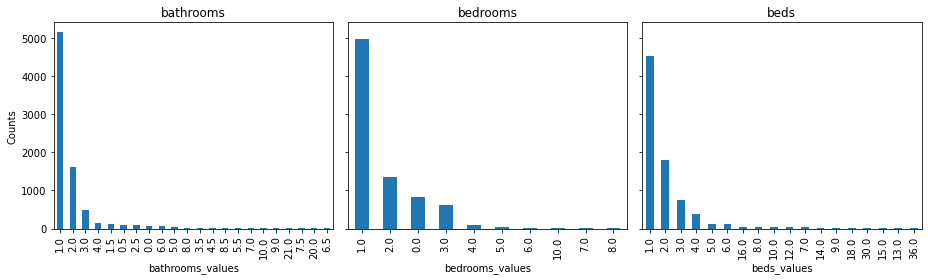

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

data['bathrooms'].value_counts().plot(kind='bar', ax=ax1)
data['bathrooms'].fillna(data['bathrooms'].value_counts().index[0], 
                         inplace=True)
data['bedrooms'].value_counts().plot(kind='bar', ax=ax2)
data['bedrooms'].fillna(data['bedrooms'].value_counts().index[0], 
                        inplace=True)
data['beds'].value_counts().plot(kind='bar', ax=ax3)
data['beds'].fillna(data['beds'].value_counts().index[0], inplace=True)

ax1.set_title('bathrooms')
ax2.set_title('bedrooms')
ax3.set_title('beds')

ax1.set_ylabel('Counts')
ax1.set_xlabel('bathrooms_values')
ax2.set_xlabel('bedrooms_values')
ax3.set_xlabel('beds_values')

plt.tight_layout()
data['neighborhood_overview'].fillna('', inplace=True)

**Figure 5.2.1** Frequencies of Values for Features `bathrooms`, `bedrooms` and `beds`

### 5.3 Handling of Outliers

Float values were observed under the feature `bathrooms`. The feature should contain only counting numbers but decimals were observed such as 1.5, 0.5, 8.5, etc. Thus, floating values will be rounded up to the nearest integer. 

For the numerical features, the boxplots are given by Figure 5.3.1. The features `accomodates`, and `bedrooms` have relatively good distribution with very few data points lying above the upper quartile. On the other hand, the features `bathrooms`, `beds` and `minimum_nights` shows some significant number of outliers - these outliers are 2-3x greater than the upper quartile. For objectivity, Interquartile (IQR) method with 4.0 factor threshold was used to filter out the outliers on the extremities [B]. This means that values above 4x the IQR ($\text{IQR}_{75}-\text{IQR}_{25}$) will be removed. Using the IQR method, a total of 1,111 number of outliers were removed, which is around 14% of the dataset. For comparison, the boxplots of the numerical features after removing the outliers are shown in Figure 5.3.2. Based on Figure 5.3.2, most of the data on the upper extremities were removed.

In [7]:
print('Before: ', list(np.unique(data['bathrooms'])))
data['bathrooms'] = data['bathrooms'].transform(np.ceil)
print('After: ', list(np.unique(data['bathrooms'])))

Before:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 10.0, 20.0, 21.0]
After:  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 21.0]


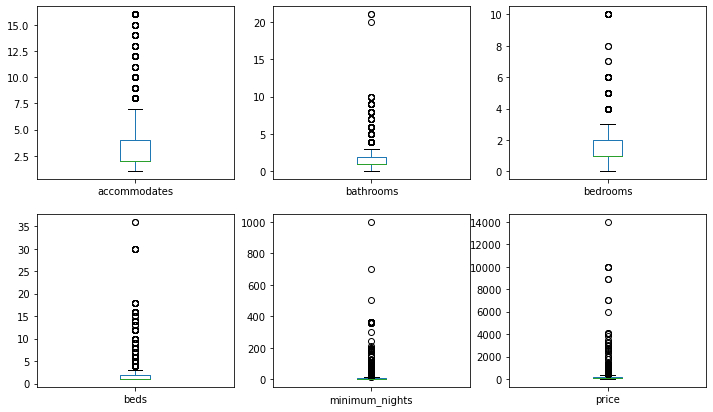

In [8]:
# list of numerical features - discrete and continuos
col_list = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 
            'minimum_nights', 'price']

# Draws the boxplt of each feature
fig, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 7))
ax_list = [ax1, ax2, ax3, ax4,ax5, ax6]
for i in range(len(col_list)):
    data[col_list[i]].plot(kind='box', ax=ax_list[i])

**Figure 5.3.1.** Boxplots Before Outlier Filtering

In [9]:
print('Size before removing outliers: ', data.shape)

# Outlier Detection and Filtering Using IQR Method
for i in range(len(col_list)):
    # calculate interquartile range
    col_name25 = 'q25_' + col_list[i]
    data[col_name25] = np.percentile(data[col_list[i]], 25)

    col_name75 = 'q75_' + col_list[i]
    data[col_name75] = np.percentile(data[col_list[i]], 75)
    
    # calculate the outlier cutoff
    col_namecut = 'cut_' + col_list[i]
    data[col_namecut] = (data[col_name75] - data[col_name25])*4

    col_namelow = 'low_' + col_list[i]
    data[col_namelow] = data[col_name25] - data[col_namecut] 

    col_nameup = 'up_' + col_list[i]
    data[col_nameup] = data[col_name75] + data[col_namecut] 
    
    # identify outliers
    col_nameout = 'out_' + col_list[i]
    data[col_nameout] = (data[col_list[i]] < data[col_namelow])  | (
        data[col_list[i]] > data[col_nameup])
    
    # drop intermediate columns
    data.drop(columns=[col_name25, col_name75, col_namecut, col_namelow, 
                       col_nameup], inplace=True)

data['sum'] = data[['out_' + col_list[i] for i in range(
    len(col_list))]].sum(axis=1) > 0

# remove outliers
data = data.loc[~data['sum']].iloc[:, :-7].copy()

print('Size after removing outliers: ', data.shape)


Size before removing outliers:  (7975, 12)
Size after removing outliers:  (6864, 12)


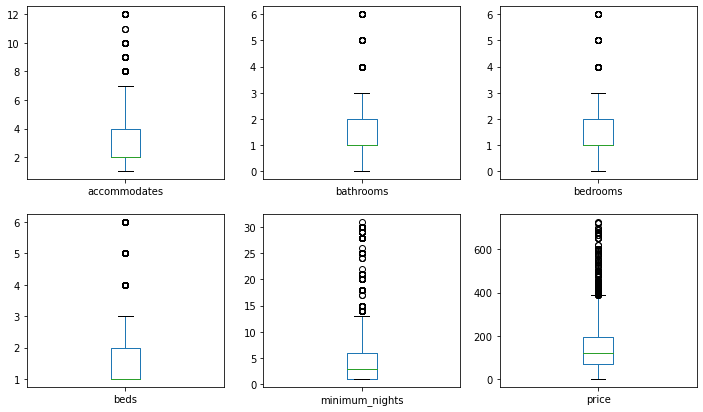

In [10]:
# Draws the boxplot after filtering the outliers
fig, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 7))
ax_list = [ax1, ax2, ax3, ax4,ax5, ax6]
for i in range(len(col_list)):
    data[col_list[i]].plot(kind='box', ax=ax_list[i])

**Fgure 5.3.2.** Boxplots After Outlier Filtering

## 6 Bivariate Analysis

The heatmap presented in Figure 6.1a shows partial collinearities between the following features: `accommodates`, `bedrooms`, `bathrooms`, and `beds`. The strongest linear correlation was observed on beds vs acccomodates. As expected, these features would have some degree of collinearity since the capacity to acccomodate means more bedrooms and beds. In order to eliminate collinearities, variance inflation factors (VIF) were calculated. The VIF factor measure the increase in the variance of the parameter estimate if an additional variable is added to a linear regression. Thus, a high VIF factor is indicative of high degree of collinearity.

The highest VIF factor was obtained for the feature `accommodates` (Figure 6.1b). Typically, a VIF of $>10$ indicates high collinearity. Thus, the feature `accommodates` will be removed from the dataset. The new calculated VIFs are now given in Figure 6.1c.

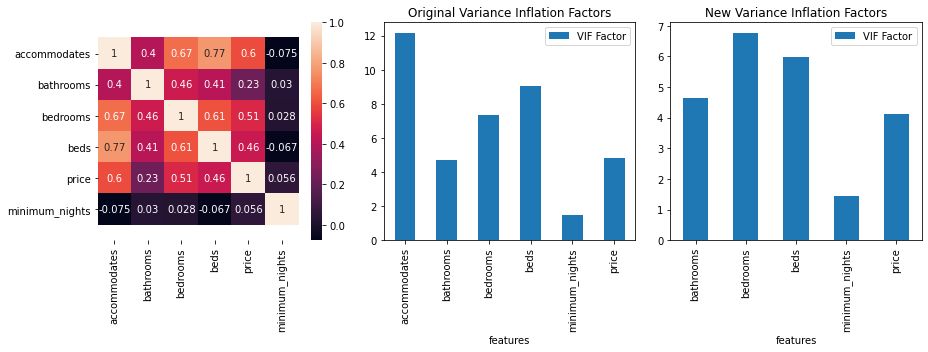

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,5))

# Draws the  correlation heatmap for numerical features
sns.heatmap(data.corr(), annot=True, ax=ax1)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax3.set_title('Correlation Heatmap for Numerical Features')

# Shows the Original Variance Inflation Factors
X =  data[col_list]
X.values
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i
                     in range(X.shape[1])]
vif["features"] = X.columns
vif.set_index('features').plot(kind='bar', ax=ax2)
ax2.set_title('Original Variance Inflation Factors')
# ax2.set_ylabel('Variance Inflation Factors (VIF)')

# Shows the VIF after Eliminating Collinearities
X =  data[col_list].drop(columns='accommodates')
X.values
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i
                     in range(X.shape[1])]
vif["features"] = X.columns
vif.set_index('features').plot(kind='bar', ax=ax3)
ax3.set_title('New Variance Inflation Factors')

plt.tight_layout()

data.drop(columns='accommodates', inplace=True)

**Figure 6.1.** (a) Correlation Heatmap for Numerical Features; (b) Orignal Variance Inflation Factors; (c) New Variance Inflation Factors

## 7 Initial Exploratory Data Analysis

The objective in this section is to give an initial overview of the data without prior knowledge about the cluster labels. This section aims to give a brief overall analysis of the raw data.

**Summary Statistics of Airbnb listing prices**

Shown in Table 7.1 is the summary statistics for the prices. The maximum price lsited was 728 while the minimum s 0. The average price is 144. Almost one-half or 50 percent of the listings are priced lower than the average. It was also observed that the most frequent price was 60 and the median price was 120.

**Table 7.1** Summary Statistics of Prices

In [12]:
data['price'].describe()

count    6864.000000
mean      144.535402
std       100.993482
min         0.000000
25%        68.000000
50%       120.000000
75%       196.000000
max       728.000000
Name: price, dtype: float64

In [13]:
print('The most frequent price point is $', data['price'].mode()[0])
print('The median price point is $', data['price'].median())

The most frequent price point is $ 60
The median price point is $ 120.0


The mean price point is greater than both median and mode while the median is greater than the mode. This implies that the price is positively skewed.

**What is the distribution of the listing price?**

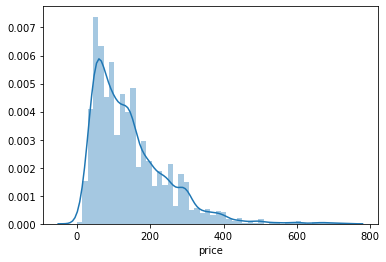

In [14]:
sns.distplot(data['price'])

**Figure 7.2.** Distribution of Price

The histogram further proves that majority of the prices are positively skewed. 

**Do Airbnb guests prefer to book a private room or shared room?**

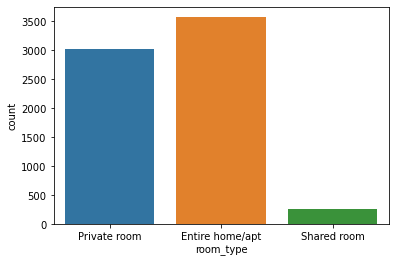

In [118]:
sns.countplot(data['room_type'])

**Figure 7.3.** Counts of Rooms Types

Airbnb users prefer to book rooms that are private that shared. Moreover, there are more bookings that book an entire home or apartment for themselves.

**How many nights do Airbnb guests stay in the booked place?**

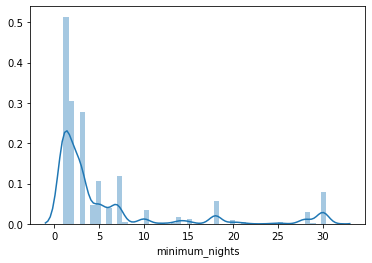

In [120]:
sns.distplot(data['minimum_nights'])

**Figure 7.4**. Distribution of Number of Minimum Nights

## 8 Feature Engineering

In preparation for clustering, features must be preprocessed, engineered, reduced, encoded and scaled. There are several advantages for doing so which includes but not limited to the following:<br>
**(1)** Feature engineering reduces the variance of the data, which in turn makes the clusters more defined and interpretable.<br>
**(2)** It reduces run-time exponentially.<br>
**(3)** Decreases the likelihood for curse of dimensionality.<br>

This section is divided into four (4) subsection listed below. The techniques applied for feature engineering are discussed in the subsequent subsections. Under 7.4, a subsection for the discussion on the principal components and their meanings was included. The implications of the results obtained from SVD will be used in the subsequent analysis of clusters.

- **8.1** Vectorization of Categorical-Nominal Features
- **8.2** Logarithmic Transformantion for Numerical-Continuous Features
- **8.3** One-Hot Encoding for Nominal-Categorical Features
- **8.4** Dimensiionality Reduction by Singular Value Decomposition (SVD)
    - **8.4.1** Analysis of Principal Components

Feature mapping will not be done in this study since all categorical features are nominal subtype.

### 8.1 Vectorization of Categorical-Nominal Features

The values under the feature `amenities` are given as string enclosed in braces `{`, `}`. Thus, in order to extract the relevant information, these values were stripped, tokenized and vectorized based on their respective frequencies (Bag-of-Words representation). Irrelevant tokens such as `in`, `of` and the likes were removed to reduce the size of the resuting dataset, NaN values were replaced by **0**. This vectorization resulted to additional **182** columns in the data frame.

The values under the feature `neighborhood_overview` are also given as list of strings. Thus, the same method was employed to extract the relevant information. That is, the values were stripped, tokenized and vectorized based on their respecttive frequencies. Similarly, irrelevant tokens were removed to reduce the resulting size of the dataset. NaN values were replaced by **0**. This vectorization resulted to additional **8741** columns in the data frame.

In [15]:
## vectorize amenities

## list the irrelevant words
irr_words = ['the', 'and', 'to', 'of', 'in', 'is', 'a', 'from', 'for', '-', 
             'are', 'at', 'etc', 'or', '&', 'that', 'will', 'an', 'with', 
             'as', '2', 'it', 'premises', 'allowed', 'be', 'head', 'on', 
             'tanjong', 'can', 'located', 'just', 'not', 'min', 'tiong', 
             'many', 'within', 'first', 'self', 'by', 'there', 'we', 
             'on', 'check', 'about', 'out', 'bharu', 'translation', 'you', 
             '/', 'off']

irr_words_col = ['amenities_' + word for word in irr_words] + ['amenities']

def to_bow(docs):
    """Converts the string of words into bag-of-words representation
    """
    my_list = [dict(Counter(doc.lower().split())) for doc in docs]
    df = pd.DataFrame(my_list).fillna(0)
    return df.reindex(sorted(df.columns), axis=1)

## Strips the braces and splits each text into tokens
stripped = [string.strip('{').strip('}').split(',') for string in list(
    data['amenities'].values)]

## Removes double and single quotations
stripped_list = []
for group in stripped:
        stripped_list.append([word.strip('''"''').strip("'") for word in 
                              group])

## Converts the list into bag-of-words
bow_list_amenities = []
for group in stripped_list:
    bow_list_amenities.append(to_bow(group).sum())

    
## Concatenates and stores the BOW into DataFrame
cat_amenities = pd.concat(bow_list_amenities, axis=1).fillna(0)
cat_amenities = cat_amenities.T.copy()
cat_amenities.columns = ['amenities_'+name for name in 
                         cat_amenities.columns.to_list()]

## Joins the BOW into the original Dataframe
data1 = pd.concat([data.reset_index(drop=True), 
                   cat_amenities.reset_index(drop=True)], axis=1)

## Removes irrelevant tokens from the BOW
for col in irr_words_col:
    try:
        data1.drop(columns=col, inplace=True)
    except KeyError:
        continue

In [16]:
print(f'Number of Features Before Vectorization of Amenities: {data.shape[1]}')
print(f'Number of Features After Vectorization of Amenities: {data1.shape[1]}')

Number of Features Before Vectorization of Amenities: 11
Number of Features After Vectorization of Amenities: 193


In [17]:
## vectorize neighborhood overview
irr_words_col_neigh = ['neighborhood_overview_' + word for word in irr_words] 
+ ['neighborhood_overview']

stripped_neigh = data1['neighborhood_overview'].to_list()

text_list = [text.split(' ') for text in stripped_neigh]

group_list = []
for group in text_list:
    group_list.append([word.strip().strip("'").strip('''"''').strip(
        '.').strip('(').strip(')').strip('!') for word in group])

bow_list_neigh = []
for group in group_list:
    bow_list_neigh.append(to_bow(group).sum())
    
cat_neigh = pd.concat(bow_list_neigh, axis=1).T.fillna(0)

cat_neigh.columns = ['neighborhood_overview_'+name for name in 
                     cat_neigh.columns.to_list()]
data2 = pd.concat([data1.reset_index(drop=True), 
                   cat_neigh.reset_index(drop=True)], axis=1)

for col in irr_words_col_neigh:
    try:
        data2.drop(columns=col, inplace=True)
    except KeyError:
        continue

In [18]:
print(f'Number of Features Before Vectorization of neighborhood_overview: {data1.shape[1]}')
print(f'Number of Features After Vectorization of neighborhood_overview: {data2.shape[1]}')

Number of Features Before Vectorization of neighborhood_overview: 193
Number of Features After Vectorization of neighborhood_overview: 8934


### 8.2 Logarithmic Transformation of Numerical-Continuous Features

In this subsection, numerical-continuous features skewness will be explored. The objective is to transform these features so that the resulting distribution will have good skewness and as close as possible to normal distribution. In the dataset, there is only one numericl-continuous feature - `price`. As observed from Figure 8.2.1 density plot below, the originall distribution is skewed to the right. Thus, logarithmic transformation was used to reduce the skewness and make the data more conforming to normal distribution. The transformation takes the form

$$
f(x) = \log{(x+1)}
$$

Figure 8.2.1. compares the density plots before and after log-transformation. The skewness before and after the log-transfomation were also measured. As expected, the asbolute skewness became closer to 0 which is the ideal value for the normal distribution.

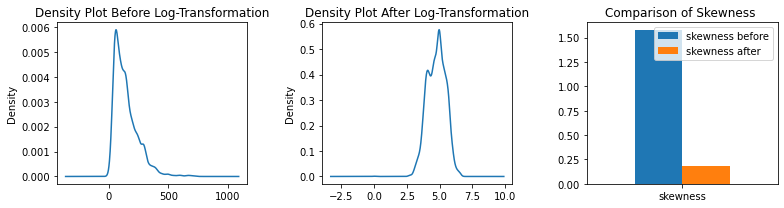

In [19]:
from scipy.stats import kurtosis, skew
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11,3))

# Plots the distribution before log-transformation

data2['price'].plot(kind='density', ax=ax1)
ax1.set_title('Density Plot Before Log-Transformation')


# Performs Log-Transformation

data2['log_price'] = (data2['price'] + 1).transform(np.log)
data2_ = data2.drop(columns='price')

# Plots the distribution after log-transformation

data2_['log_price'].plot(kind='density', ax=ax2)
ax2.set_title('Density Plot After Log-Transformation')


# Plots the skewness before and after  Log-transformation

df = pd.DataFrame([skew(data2['price']), np.abs(skew(data2_['log_price']))]).T
df.columns = ['skewness before', 'skewness after']
df.plot(kind='bar', ax=ax3)
ax3.set_xticklabels(labels=['skewness'], rotation='horizontal')
ax3.set_title('Comparison of Skewness ')

plt.tight_layout()

data2.drop(columns='price', inplace=True)

**Figure 8.2.1** Comparison of Density Plots of Price Before and After Logarithmic Transformation

### 8.3 One-Hot Encoding for Nominal Categorical Features

The nominal categorical features such as `property_type`, `room_type`, `bed_type`and `instant_bookable` were one-hot encoded and the last column was dropped to reduce the number of dimensions. This would not result to information loss since for one-hot encoding, in the resulting columns there is at least one feature that is lineary dependent to the rest of the features. 

In [20]:
## one-hot encode nominal categorical features

cols = [col + '_' + data2[col].unique()[0] for col in ['property_type', 
                                                       'room_type', 
                                                       'bed_type', 
                                                       'instant_bookable']]
X = pd.get_dummies(data2).drop(columns=cols)

### 8.4 Dimensionality Reduction by Singluar Value Decomposition

It is imperative to combine related features and select the most important linear combinations of these features (principal components) in order to reduce the number of dimensions in the dataset, especially for one-hot encoded Bag-of-Words representations of `neighborhood_overview` and `amenities`. This is useful for clustering sub features of `neighborhood_overview` which only contains **1-2** instances in the whole data set. In addition, the number of features (**8959**) of the dataset is much greater than the number of objects (**6864**) which is  prone to the curse of dimensionality. 

Since the data contains one-hot encoded or sparse features, Singular Value Decomposition (**SVD**) was used to reduce the number of dimensions. For initial estimation, the ThresholdVariance set at **90%** was used to estimate the resulting number of the most important features. The result was assumed equal to the number of linear combinations of the most important features. The linear combinations of the important features are the most important principal components. 

From the result of the ThresholdVariance, the size was reduced from **8959** to **163**. Hence, the data was truncated by SVD using **163** principal components.

The resulting plots of variances explained are show in Figure 8.4.1. Based from the plots, the first and most importance feature already explains more than **45%** of the total variance of the data. The second most important feature gives around **5%**. At **90%** variance explain threshold, the estimated number of principal components is around **165**. Thus, the initial estimated number of components using the VarianceThreshold was accurate.

In [22]:
# set the variance threshold

p = 0.9
sel = VarianceThreshold(threshold=(p * (1 - p)))
X_reduced_variance = sel.fit_transform(X.values)
print('Size before Variance Threshold reduction: ', X.values.shape)
print(f'Estimated size after {p*100}% Variance Threshold reduction: ', 
      X_reduced_variance.shape)

Size before Variance Threshold reduction:  (6864, 8959)
Estimated size after 90.0% Variance Threshold reduction:  (6864, 163)


In [23]:
svd = TruncatedSVD(n_components=163).fit(X)
X_reduced = svd.transform(X)
explained_var = svd.explained_variance_
explained_var_ratio = svd.explained_variance_ratio_
s_values = svd.singular_values_

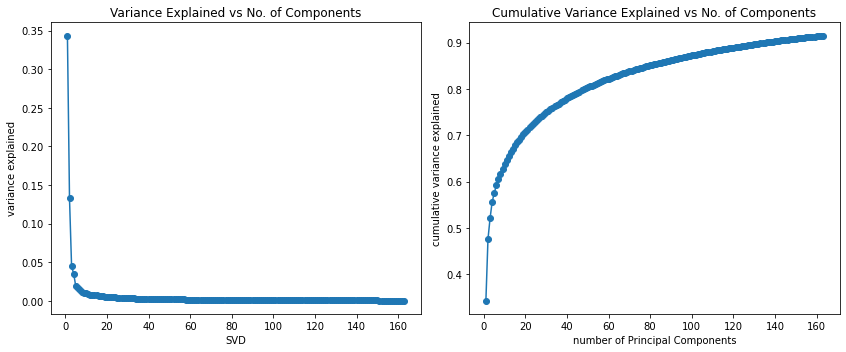

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.plot(range(1, len(explained_var_ratio)+1), explained_var_ratio, 'o-')
# ax1.set_ylim(0,1)
ax1.set_xlabel('SVD')
ax1.set_ylabel('variance explained')
ax1.set_title('Variance Explained vs No. of Components');

ax2.plot(range(1, len(explained_var_ratio)+1), explained_var_ratio.cumsum(), 
         'o-')
# ax2.set_ylim(0,1)
ax2.set_xlabel('number of Principal Components')
ax2.set_ylabel('cumulative variance explained')
ax2.set_title('Cumulative Variance Explained vs No. of Components')

plt.tight_layout()

**Figure 8.4.1** Absolute and Cumulative Variance Explained vs No. of Components

#### 8.4.1 Analysis of Principal Components

In this subsection, the weights of individual features in the top principal component was explored. In theory, the principal components represent the linear combination of the features. Usually, the top principal component is the linear combination of the most important feature - this means other lesser imporant feature may have weights of zero. The heatmap in Figure 8.4.1.1 shows the absolute weights of these features in the Top 15 principal components.

Notice that the PC-1, being the most important component, is more than **80%** related to the feature `minimum_nights`. The feature `minimmumm_nights` also explain **50%** the second most important principal component. This means that this feature `minimum_nights` is the most important feature. And this feature is expected to be the top differentiator of the resulting clusters after conducting clustering.

The second most important feature is the price. The feature `log_price` constitutes **50%** of **PC-2**. From Figure N.n., there is a large difference between the variance explained by the `minimum_nights` and the `price`. This means that the relative importance of the feature `log_price` can be much lower than the feature `minimum_nights`. 

The feature `bed` comes in third position, contributing **30-40%** of **PC-9** and **PC-10**. Other features having relatively high weights include `amenities_dryer`, `bathrooms`, and `bedrooms`.

Text(0.5, 1.0, 'Feature Weights in Top 15 Principal Components')

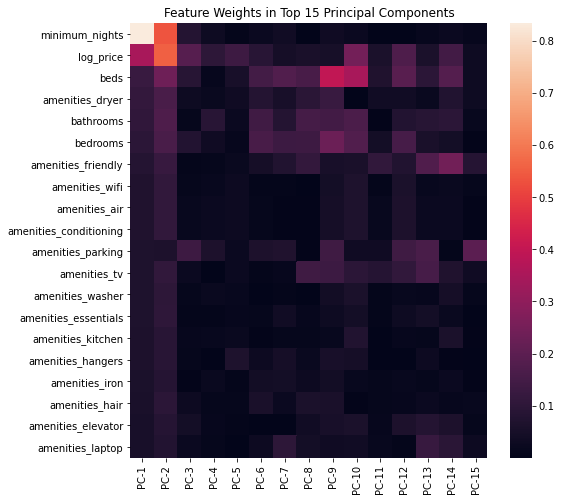

In [25]:
i = np.identity(X.shape[1])
weights = pd.DataFrame(svd.transform(i), index=X.columns)
weights.columns = [f'PC-{i+1}' for i in weights.columns]
weights = weights.transform(np.abs).copy()

fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.heatmap(weights.sort_values(by='PC-1', ascending=False).iloc[:20, :15], 
            ax=ax)
ax.set_title('Feature Weights in Top 15 Principal Components')

**Figure 8.4.1.1** Absolute Weights of Features to Top15 Principal Components

## 9 Clustering

In this section, the reduced dataset was clustered using KMeans and Agglomerative clustering (avearage lingkage). This section is divided into three subsections: 
- **9.1** K-means and Agglomerative Clustering
    - **9.1.1** Selection of Best k
- **9.2** Feature Importance Ranking

### 9.1 K-means and  Agglomerative Clustering

K-means clustering is a widely used clustering algorithm. For unsupervised learning, K-means is being run for several values of $k$ and the resulting clusters are evaluated by several validation criteria. K-means clusters data by grouping the samples of equal variance, that is by minimizing the inertia of within cluster sum of squares. The centroids are chosen which would result to the  minimum within cluster sum of squares.

The assumption for KMeans is that the data is convex and isotropic. For elongated data, this algorithm works poorly. In this study, KMeans was used to check how the algorithm will respond to the shape of the data. Tolerance was set at $10^{-4}$ and maximum number of iterations was set at **300**. 

In order to visually check the geometry of the clusters, the orignal data was reduced into two dimension using SVD, then plotted with the predicted labels for each objects. The clusters are presented in Figure 9.1.1. As observed, the data is not convex, i.e. it is elongated. However, the KMeans alogrithm was able to cluster it good enouugh for $k=3$ and $k=4$. For $k=5$ and $k=6$, the clusters are overlapping and no clear boundaries are observed. 

For comparison, Agglomerative Clustering was also used with `ward` criteria. Agglomerative Clustering or Hierarchical Clustering build nested clusters by successive merging or splitting. The clusters can be represented as leaves connected to the tree or trunk with the parent cluster. In this study, the criteria used was ward wherein the sum of squared differences within all clusters is minimized.

The Agglomerative Clustering was also done for several values of $k$. For visual comparison, the plot of the clusters are shown in Figure 9.1.2. For $k=3$, the clusters defined from KMeans and Agglomerative Clustering are almost the same. However, some data points (yellow) in Agglomerative clustering overlaps with the other clusters. For $k=4$, there are significant number of overlapping points from different clusters. For $k=5$ and $k=6$, the Agglomerative clustering did not yield well-defined clusters.

Thus, by visual inspection, KMeans was able to classify the dataset better than Agglomerative clustering. In the next section, the validation measures will be explored to select $k$ for KMeans.

In [75]:
def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    Q_j = np.zeros(len(np.unique(y)))
    for index, cluster_i in enumerate(y):
        Qj_col = {v: k for k, v in enumerate(np.unique(y))}
        Q_j[Qj_col[cluster_i]] += dist(X[index, :], centroids[cluster_i, :])**2
    return sum(0.5*Q_j/np.unique(y, return_counts=True)[1])

def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    """Compute the gap statistic
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(random_state)
    W_ki = []
    for i in range(b):
        distribution = rng.uniform(X.min(0), X.max(0), X.shape)
        realizations = clusterer.fit_predict(distribution)
        W_ki.append(np.log(pooled_within_ssd(distribution, realizations, 
                                             clusterer.cluster_centers_, 
                                             dist)))
    E_logWk = np.mean(W_ki)
    Gap = E_logWk - np.log(pooled_within_ssd(X, y, centroids, dist))
    return Gap, np.std(W_ki)

inertia = []
CH = []
SC= []
GS = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced)
    y_pred = km.predict(X_reduced)
    inertia.append(km.inertia_)
    CH.append(calinski_harabasz_score(X_reduced, y_pred))
    SC.append(silhouette_score(X_reduced, y_pred))
    GS.append(gap_statistic(X_reduced, y_pred, km.cluster_centers_, euclidean,
                            len(np.unique(y_pred)), KMeans(n_clusters=k),
                            random_state=42)[0])

In [76]:
## Plot the clusters

## transform data into 2d using truncated svd

X_trunc = (TruncatedSVD(n_components=2)
                    .fit_transform(X_reduced))
y_pred_list = []
for k in range(3, 7):
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced)
    y_pred_list.append(km.predict(X_reduced))

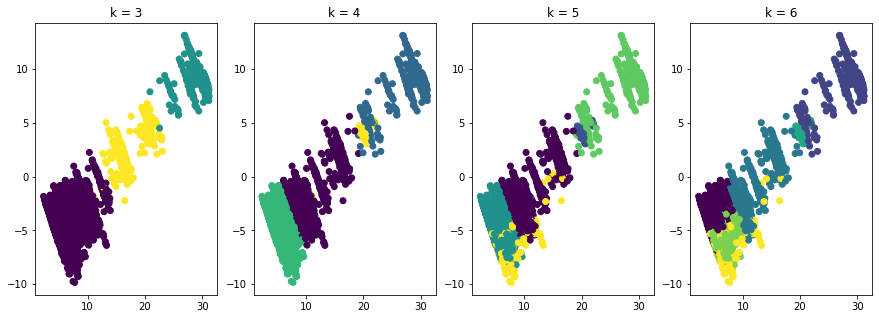

In [77]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(15, 5))
ax_list = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax_list[i].scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[i])
    ax_list[i].set_title(f'k = {i+3}')

**Figure 9.1.1** 2D Plots of Clusters (KMeans)

In [78]:
y_pred_list_agg_ward = []
for k in range(3, 7):
    agc = AgglomerativeClustering(n_clusters=k, 
                                  linkage='ward').fit_predict(X_reduced)
    y_pred_list_agg_ward.append(agc)

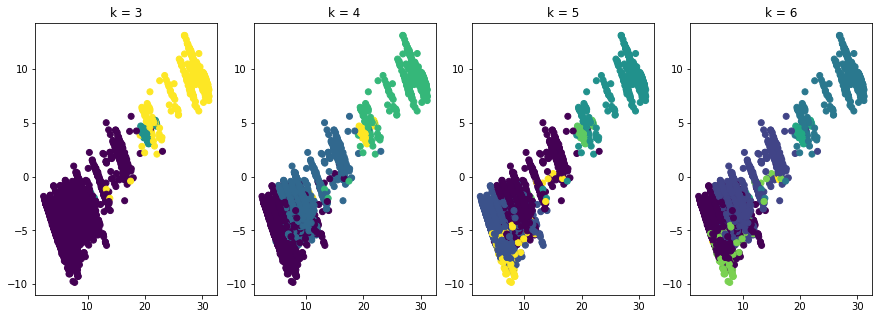

In [79]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(15, 5))
ax_list = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax_list[i].scatter(X_trunc[:, 0], X_trunc[:, 1], 
                       c=y_pred_list_agg_ward[i])
    ax_list[i].set_title(f'k = {i+3}')

**Figure 9.1.2** 2D Plots of Cluster (Agglomerative Clustering)

#### 9.1.1 Selection of Best k

For objectivity, the best $k$ for KMeans was selective using four validation criteria: Calinski-Harabasz Index, Inertia, Silhouette Coefficient and Gap Statistics. Calinski-Harabas Index represents the ratio of the between-clusters dispersion mean and the within-cluster dispersion. The higher the value of Calinski-Harabas Index, the more defined the clusters are. Inertia represents the sum of squares distances to the representative points. The optimum $k$ is given by the elbow in the trend of Inertia vs $k$. Silhouette Coefficient measures the mixing of data point from one cluster to another. Large positive values means highly separated clusters while negative values correlates with some degree of mixing of data points of clusters. Gap statistics compares the observed within-cluster sum-of-squared-distances with a reference null distribution generated using a Monte Carlo method approach. For the Gap Statistics, the best $k$ is given by the smallest $k$ such that $Gap_n(k) \geq  Gap_n({k+1})$.

The aforemetioned validation scores were calculated for KMeans at differnt values of $k$. The trend lines are given in Figure 9.1.1.1. The trends of Calinski and Inertia did not yield sufficient indication to estimate the best $k$. However, the trends of Silhouette Coefficient and Gap statistics both showed an optimum $k$ at $k=4$. The trend of the Silhouette Coefficient started to plateau at $k=4$. This means that there is no  more significant improvement in silhouette coefficient as $k$ is increased further. For Gap Statistics, the trend line decreased from $k=4$ to $k=5$. Thus $k=4$ satisfies the condition $Gap_n(k=4) \geq Gap_n(k=5)$. The rest of $k$ values already have and Gap Statistics. Based on these validation criteria, the best value of $k$ is $4$.

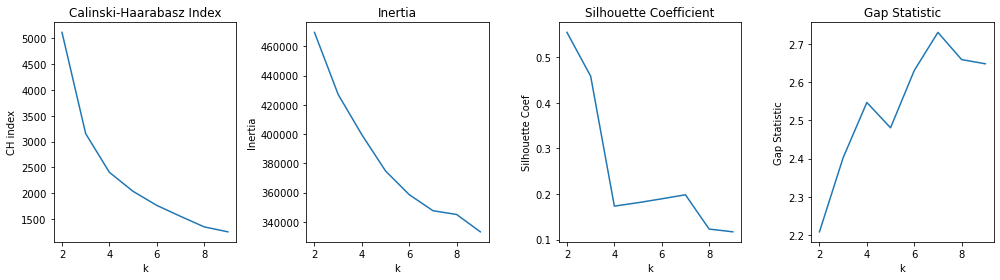

In [80]:
## check the trend of scores

scores_df = pd.DataFrame([inertia, CH, SC, GS]).T
scores_df.columns = ['inertia', 'CH', 'SC', 'GS']
scores_df.index = range(2,10)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(14,4))
scores_df['CH'].plot(kind='line', ax=ax1)
scores_df['inertia'].plot(kind='line', ax=ax2)
scores_df['SC'].plot(kind='line', ax=ax3)
scores_df['GS'].plot(kind='line', ax=ax4)

ax1.set_title('Calinski-Haarabasz Index')
ax1.set_ylabel('CH index')
ax1.set_xlabel('k')
ax2.set_title('Inertia')
ax2.set_ylabel('Inertia')
ax2.set_xlabel('k')
ax3.set_title('Silhouette Coefficient')
ax3.set_ylabel('Silhouette Coef')
ax3.set_xlabel('k')
ax4.set_title('Gap Statistic')
ax4.set_ylabel('Gap Statistic')
ax4.set_xlabel('k')

plt.tight_layout()

**Figure 9.1.1.1.** Validation Scores from KMeans at Different k

### 9.2 Feature Importance and Ranking

In Section 7, the principal components were defined and it was observed that the top component is dominantly explained by the feature `minimum_nights`. It was also shown that more than **45%**  of the variance in the data is explained solely by this feature. In order to determine which features are the most imporant, the features were ranked based on their mutual information score from the predicted labels using KMeans. Mutual Information Score measures the dependency between two random variable. It has a non-negative value. Highly positive value mean great dependency between two random variable while a value of 0 means completely independent. Mutual information score is non-parametric and can capture any kind of statistical dependency - the reason being why this method was chosen for scoring.

Figure 9.2.1 shows the ranking of the top 20 features based on importance. The feature `minimum_nights` which was one of the dominant feature in PC-0, turned out to be the fourth most imporant feature. The top and most imporant feature is the feature `bathrooms`, followed by `bedrooms` and `beds`. The top feature is 8x more important than the top 10-20 features such as `amenities_cable` and `log_price`. It is interesting to note that the feature `log_price` is only the Top 19 important feature. This  means that other features such as the number of minimun nights, number of beds and bed rooms are more differentiating factors for the segments obtained in the clustering. 

In the subsequent section, the customer segments will be defined and explored further in terms of these features.

In [84]:
## rank features according to importance

km = KMeans(n_clusters=4, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced)
bestk = SelectKBest(score_func=mutual_info_classif, k='all')
bestk.fit(X_reduced_variance, km.predict(X_reduced))
scores_list_bestk = list(bestk.scores_)

Text(0.5, 0, 'Mutual Information Score')

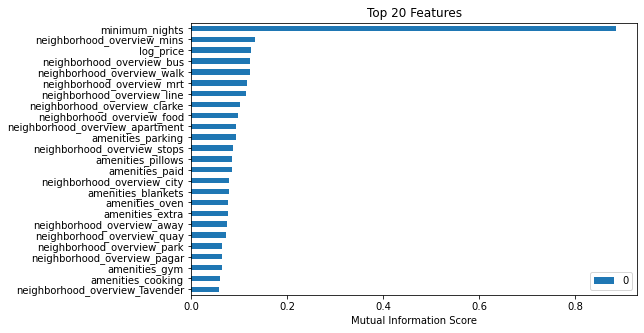

In [86]:
feature_rank_df = pd.DataFrame(scores_list_bestk).T
feature_rank_df.columns = np.array(X.columns)[sel.get_support()]
feature_rank_df.T.sort_values(by=0)[-25:].plot(kind='barh', figsize=(8,5))
plt.title('Top 20 Features')
plt.xlabel('Mutual Information Score')

**Figure 9.2.1** Top Features based on Mutual Information Score

## 10 Customer Segmentation: Analysis and Exploration

In this section, the customer segments will be defined and differentiated. This section will highlight how customer segments  vary across different features such as the minimum nights, bed rooms, number of beds, number of bathrooms, location, sought-after amenities, and room_type.

In [88]:
## exploring the customer segments

predicted_data = data2.copy()
predicted_data['segment'] =  KMeans(n_clusters=4, max_iter=300, tol=1e-4,
                                    n_jobs=-1).fit_predict(X_reduced)
predicted_data['price'] = predicted_data['log_price'].apply(lambda x:
                                                            np.exp(x)-1)

segment_A = predicted_data[predicted_data['segment']==0]
segment_B = predicted_data[predicted_data['segment']==1]
segment_C = predicted_data[predicted_data['segment']==2]
segment_D = predicted_data[predicted_data['segment']==3]

**How many Airbnb bookings or customers are there in each market segment?**

In [90]:
segment_count = predicted_data['segment'].value_counts(sort=False)
print(segment_count)

0    4704
1    1380
2     542
3     238
Name: segment, dtype: int64


Market segment A, B, C, and D have 4704, 1380, 542, and 238 bookings respectively.

**What are the minimum number of nights preferences of the market segments?**

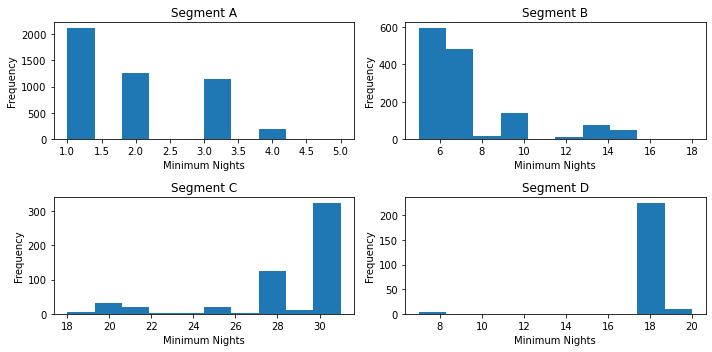

In [91]:
## explore differences in minimum nights of different segments

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))
ax_list = [ax1, ax2, ax3, ax4]

name = ['A', 'B', 'C', 'D']
for i in range(4):
    predicted_data[predicted_data['segment']==i]['minimum_nights'].plot(
        kind='hist', ax=ax_list[i])
    ax_list[i].set_xlabel('Minimum Nights')
    ax_list[i].set_title(f'Segment {name[i]}')

plt.tight_layout()

**Figure 10.1.** Comparison of Minimum Nights at Different Segments

Segment A customers are short-term travelers mostly staying a maximum of 4 nights in a place. Segment C customers are long term travelers staying from a minimum of 18 nights to a maximum of 30 nights, while Segment D are medium-term travelers who stay around 18-20 nights. Lastly, Segment B are short to medium-term travelers spending 6 to 18 nights.

**What is the preferred neighborhood overview of the market segments?**

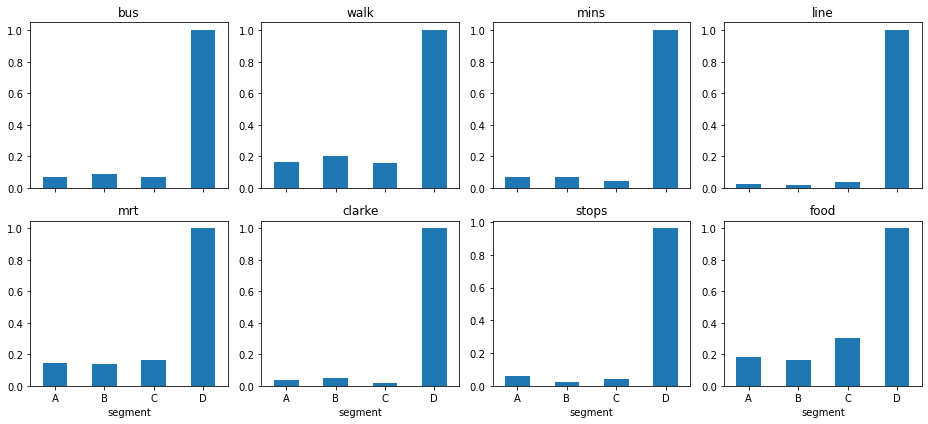

In [95]:
## explore differences in neighborhood overview at different segments

neighborhood = ['neighborhood_overview_bus',
 'neighborhood_overview_walk',
 'neighborhood_overview_mins',
 'neighborhood_overview_line',
 'neighborhood_overview_mrt',
 'neighborhood_overview_clarke',
 'neighborhood_overview_stops',
 'neighborhood_overview_food',]

fig, ((ax1, ax2, ax3, ax4),
      (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4,figsize=(13,6), sharex=True)
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(len(neighborhood)):
    a = predicted_data.groupby('segment')[neighborhood[i]].agg(lambda x:
                                                               x.ne(0).sum())
    b = a/segment_count
    b.plot(kind='bar', ax=ax_list[i])
    ax_list[i].set_title(neighborhood[i].split('_')[-1])
    ax_list[i].set_xticklabels(name, rotation='horizontal')
        
plt.tight_layout()

**Figure 10.2.** Top Neighborhood Overview Descriptions

Segment A customers either comments a lot on the neighborhood overview or truly considers the neighborhood overview features mentioned above. Segment B and D customers are similarly either not bothering to comment or does not put importance on the mentioned above neighborhood overview. Segment C is similar with Segment A customers except they do not give as much consideration for stops and food as a neighboorhood overview.

**What are the pricing preference of the market Segments?**

Explain here the this segment is for economy. This one is for luxury, etc.

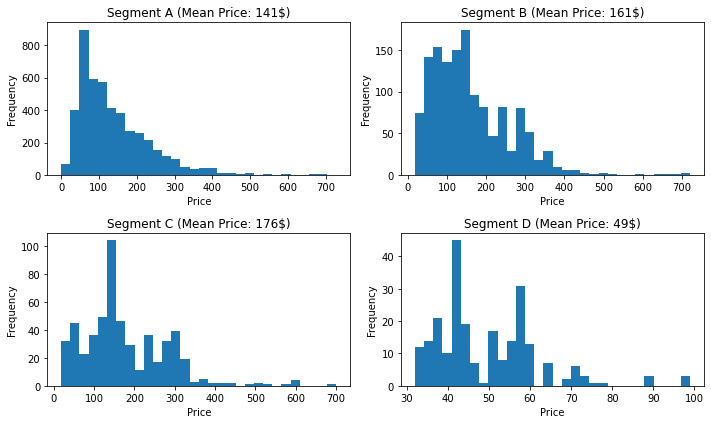

In [96]:
## explore price differences of different segments

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,6))
ax_list = [ax1, ax2, ax3, ax4]

for i in range(4):
    predicted_data[predicted_data['segment']==i]['price'].plot(kind='hist',
                                                               ax=ax_list[i],
                                                               bins=30)
    mean_price = round(
        predicted_data.loc[predicted_data['segment']==i]['price'].mean())
    ax_list[i].set_title(f'Segment {name[i]} (Mean Price: {mean_price}$)')
    ax_list[i].set_xlabel('Price')

plt.tight_layout()

<a id="table2"></a> 
<left style="font-size:12px;font-style:default;"><b>Figure 10.3 Price Distribution at Different Segments</b></left>

Clearly segment D are low-budget guests with a budget ranging from $30$ to $100$ a night. Segments A, B, and C are closely similar having guests with a wide budget ranging from $0 - $700, and having close mean prices.   

**Which Amenities are Most-Sought After?**

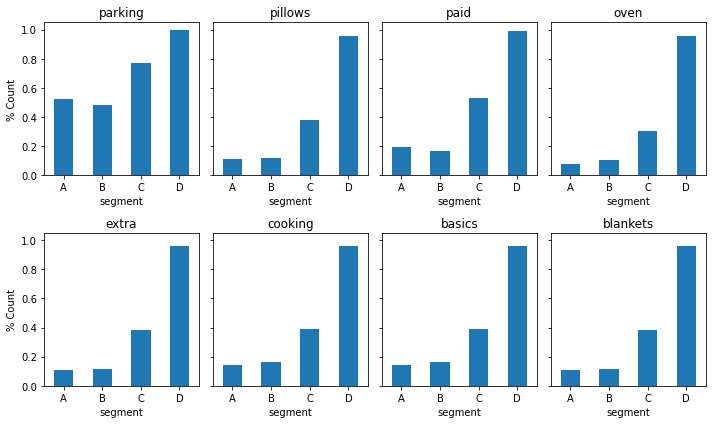

In [97]:
## explore differences in amenities at different segments

amenities = ['amenities_parking',
 'amenities_pillows',
 'amenities_paid',
 'amenities_oven',
 'amenities_extra',
 'amenities_cooking',
 'amenities_basics',
 'amenities_blankets',]
             
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(
    2, 4, figsize=(10,6), sharey=True)
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i in range(len(amenities)):
    a = predicted_data.groupby('segment')[amenities[i]].agg(
        lambda x: x.ne(0).sum())
    b = a/segment_count
    b.plot(kind='bar', ax=ax_list[i])
    ax_list[i].set_title(amenities[i].split('_')[-1])
    ax_list[i].set_xticklabels(name, rotation='horizontal')
    ax_list[i].set(ylabel='% Count')
    
plt.tight_layout()

**Figure 10.5** Top Amenities and Distribution per Segment

Among the four segment, Segment A and B customers seem to have the least interest on the amenities. Segment C customers somewhat value the amenities provided in the Airbnb while Segment D customers care about the amenties the most.

**What is the preferred property type by market segmentation?**

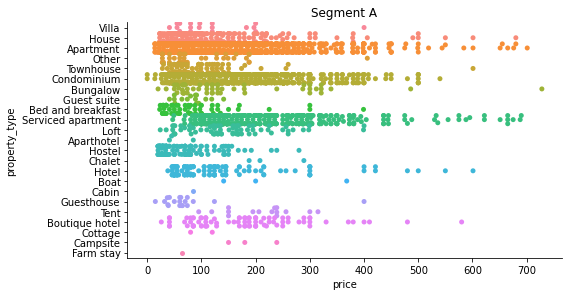

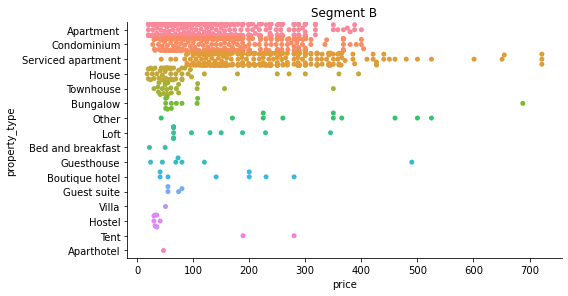

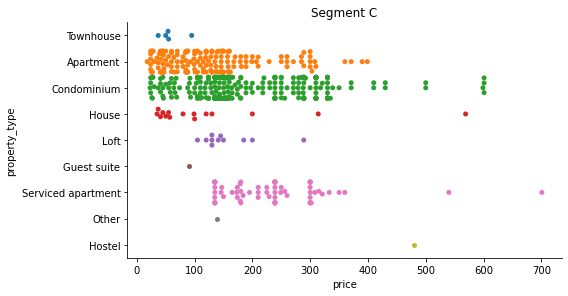

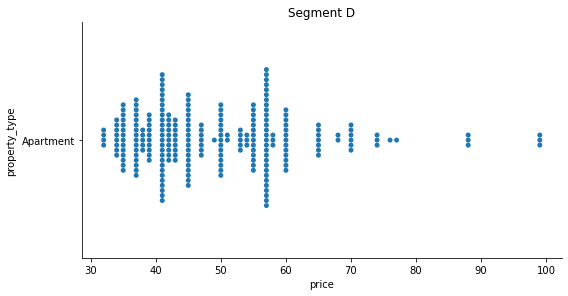

In [110]:
name = ['A', 'B', 'C', 'D']

for i in range(4):
    sns.catplot(data=predicted_data[predicted_data['segment']==i], x='price',
                y='property_type', height=4, aspect=2,
                kind='swarm').set(title='Segment ' + name[i])


**Figure 10.6.** Comparison of Room Types for Different Segments

**What are the preferred room type of the market segments?**

In [116]:
name = ['A', 'B', 'C', 'D']

for i in range(4):
    sns.catplot(data=predicted_data[predicted_data['room_type']==i],
                x='price', y='room_type', height=4, aspect=2,
                kind='count').set(title='Segment ' + name[i])


ValueError: min() arg is an empty sequence

In [ ]:
**What are the preffered bed type of the market segments?**

Overall, market segment have the following kinds of customers:

Segment A


Segment B - 

Segment C -

Segment D - Customers who prefer to spend a low budget of 30 USD to 100 USD for apartments that provide the most amenities available and best neighborhood overview available. These customers care about how they value they are getting from the apartment they rent. Hence, they could probably rent the Airbnb up to 18-20 nights due to the low price tag.

In [99]:
predicted_data

,property_type,room_type,bathrooms,bedrooms,beds,bed_type,minimum_nights,instant_bookable,amenities_air,amenities_cable,...,"neighborhood_overview_313@somerset,",neighborhood_overview_350m,neighborhood_overview_360m,neighborhood_overview_420m,neighborhood_overview_marinabay,"neighborhood_overview_trip,",neighborhood_overview_aljuned,log_price,segment,price
0,Apartment,Private room,1.0,1.0,1.0,Real Bed,6,f,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.234107,1,68.0
1,Villa,Private room,1.0,2.0,3.0,Real Bed,1,t,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.303305,0,200.0
2,House,Private room,1.0,1.0,1.0,Real Bed,1,t,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.532599,0,92.0
3,House,Private room,1.0,1.0,2.0,Real Bed,1,t,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.624973,0,101.0
4,Apartment,Private room,1.0,1.0,1.0,Real Bed,7,f,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.795791,1,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859,Condominium,Entire home/apt,3.0,5.0,5.0,Real Bed,2,t,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.888878,0,360.0
6860,Loft,Private room,1.0,0.0,1.0,Real Bed,1,t,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.218876,0,24.0
6861,Apartment,Private room,2.0,1.0,1.0,Real Bed,18,t,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.060443,3,57.0
6862,Serviced apartment,Entire home/apt,1.0,0.0,1.0,Real Bed,1,t,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.615121,0,100.0


## 10 Conclusion

In this study, the segmentation of the existing user base of AirBnB in Singapore was explored. Unsupervised clustering of Singapore Air BnB listings using both KMeans and Agglomerative Clustering were conducted. KMeans algorithm yielded better and more defined clusters for k=4, 5 and 6. Based on the validation criteria Silhouette Score and Gap Statistic, the best number of customer segment is k=4. Nonetheless, the two-dimensional plot of SVD truncated data with the predicted labels showed that clustering can still be improved using more advanced clustering methods such as DBSCAN to differentiate clusters with relatively higher density.

The top features were also ranked according to mutual information score obtained using the predicted labels from KMeans. The top feature turned out to be the number of minimum nights with a mutual information score of 0.85 which is 8x higher than the score of rest of the features. The second most important feature is accessibility with bus terminals and MRT lines. Price also turned out to be good differentiator. 

## 11 Recommendation

The two-dimensional plot of the data with predicted labels showed that the data is not convex and globular. For this reason, KMeans and Agglomerative Clustering may not be the optimum method to cluster the data. Thus, the study recommends Airbnb to use a density-based algorithm such as DBSCAN to account for the areas with relatively low density. 

It also recommends to include the review scores for each listing as well as the review comments as features. The comments can be converted into bag-of-words representation and the frequencies of token can be compared to the neighborhood description and amenities. This would help bridge the gap between what the customer really wants vs what is being offered.

It also recommends to include the location preference of the Airbnb guest. Certain guest may have a preference to visit specific continents depending on the distance and convenience. Other guest may also be adventurous so they would go farther can consider the places. The location preference may potentially show the traveling behavior of a guest.

Lastly, it also recommends that the market segmentation model will use just use the full year dataset for Singapore Airbnb listings, but also consider using the model for other countries. With an increased sample size, the clusters would be more representative significant. It may potentially increase the mutual information score. Moreover, Airbnb could also utilize other registered Airbnb users that have yet to book anything to be included in the model. They could be considered under another market segment where Airbnb would have to consider marketing to. 



## 12 References

Airbnb. (n.d.). About Us. <https://news.airbnb.com/about-us/>.

Airbnb. (n.d.). Things to do. <https://www.airbnb.com/things-to-do>.

Inside Airbnb (n.d.). *Airbnb in Singapore*. Retrieved from <http://insideairbnb.com/get-the-data.html>.

Aydin, R. (2019). How 3 guys turned renting air mattresses in their apartment into a \$31 billion company. Business Insider. Retrieved from <https://www.businessinsider.com/how-airbnb-was-founded-a-visual-history-2016-2>.

Business Models Inc. (n.d.). How Airbnb’s exponential business model works. BMI. Retrieved from <https://www.businessmodelsinc.com/exponential-business-model/airbnb/#:~:text=As%20you%20can%20see%2C%20Airbnb's,come%20from%20stays%20and%20experiences>.

Feng, C., Wang, H., Naiji, L., Chen, T., He, H., Lu, Y., & Tu, X. (2014). Log-transformation and its implications for data analysis. *Shanghai Arch Psychiatry*, 26(2), 105–109. <https://dx.doi.org/10.3969%2Fj.issn.1002-0829.2014.02.009>.

Lutz, C., & Newlands, G. (2018). Consumer segmentation within the sharing economy: The case of Airbnb. *Journal of Business Research*, 88 (2018), 187-196. <https://doi.org/10.1016/j.jbusres.2018.03.019>. 

McRae, H. (2015). Facebook, Airbnb, Uber, and the unstoppable rise of content non-generators. Independent. Retrieved from <https://www.independent.co.uk/news/business/comment/hamish-mcrae/facebook-airbnb-uber-and-the-unstoppable-rise-of-the-content-non-generators-10227207.html>.

Saad, T. (2019). Airbnb’s Growth Strategy: How they attract and retain 150 million users. Growth Manifesto. Retrieved from <https://www.growthmanifesto.com/airbnb-growth-strategy>.
